In [1]:
import ctypes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from lmfit.models import GaussianModel
from lmfit import fit_report

# Preamble, Filepath for 1pe, Functions

In [64]:
nWaveforms = 2000
maxsamples = 1500

filepath = "/home/iwsatlas1/popov/NAS_futDet/DESY_Timing_Study/1pe_Calibrations/run9-1peCal/Bulk0-Ch{}-wf{}-{}.bin"

bufferType = ctypes.c_int16 * maxsamples

segFrom = 0
segTo = nWaveforms - 1

preTrig=450
postTrig=650

preTrig2=900
postTrig2=3000

offset = 950
offset_adc = offset*32512/1000

adc_to_1000mv = 1000/32512
adc_to_50mv = 50/32512

def get1peValue(bufferData):
    average = np.average(bufferData[:, :preTrig], axis=1)
    # print("Average: {}".format(average))

    data = bufferData.astype('float64')
    data -= average[:, None]

    sums = np.sum(data[:, :postTrig], axis=1)

    return sums

def getIntegralCorr(bufferData):
    # print("Average: {}".format(average))
    data2 = bufferData.astype('float64')
    data2 -=offset_adc
    average2 = np.average(data2[:, :preTrig2], axis=1)
    data2 -= average2[:, None]
    data2 = data2 * adc_to_1000mv
    sums2 = np.sum(data2[:, :postTrig2], axis=1)

    return sums2
    

#def gaussian(x, ampl, mu, sigma):
#	return ampl / (sigma * np.sqrt(2*np.pi)) * np.exp(- (x-mu)**2 / (2 * sigma**2))


# 1pe Data read

In [65]:
readBufferA = np.zeros((nWaveforms, maxsamples), dtype=np.int16)

with open(filepath.format("A", segFrom, segTo), "rb") as file:
	for i in range(nWaveforms):
		content = file.read(ctypes.sizeof(bufferType))
		pointer = ctypes.cast(content, ctypes.POINTER(bufferType))
		readBufferA[i, :] = np.asarray(pointer.contents)

readBufferC = np.zeros((nWaveforms, maxsamples), dtype=np.int16)

with open(filepath.format("C", segFrom, segTo), "rb") as file:
	for i in range(nWaveforms):
		content = file.read(ctypes.sizeof(bufferType))
		pointer = ctypes.cast(content, ctypes.POINTER(bufferType))
		readBufferC[i, :] = np.asarray(pointer.contents)

readBufferE = np.zeros((nWaveforms, maxsamples), dtype=np.int16)

with open(filepath.format("E", segFrom, segTo), "rb") as file:
	for i in range(nWaveforms):
		content = file.read(ctypes.sizeof(bufferType))
		pointer = ctypes.cast(content, ctypes.POINTER(bufferType))
		readBufferE[i, :] = np.asarray(pointer.contents)

readBufferG = np.zeros((nWaveforms, maxsamples), dtype=np.int16)

with open(filepath.format("G", segFrom, segTo), "rb") as file:
	for i in range(nWaveforms):
		content = file.read(ctypes.sizeof(bufferType))
		pointer = ctypes.cast(content, ctypes.POINTER(bufferType))
		readBufferG[i, :] = np.asarray(pointer.contents)

# 1pe gaussian fit

Channel A 1 p.e.
	value	<Parameter 'center', value=-113748.33381927326 +/- 404, bounds=[-inf:inf]> 
	std	 <Parameter 'sigma', value=11760.584787426045 +/- 405, bounds=[0:inf]>
Channel C 1 p.e.
	value	<Parameter 'center', value=-112436.22842876363 +/- 249, bounds=[-inf:inf]> 
	std	 <Parameter 'sigma', value=12252.308571551814 +/- 250, bounds=[0:inf]>
Channel E 1 p.e.
	value	<Parameter 'center', value=-110472.18140823225 +/- 302, bounds=[-inf:inf]> 
	std	 <Parameter 'sigma', value=11687.632645292619 +/- 302, bounds=[0:inf]>
Channel G 1 p.e.
	value	<Parameter 'center', value=-115203.5108329922 +/- 307, bounds=[-inf:inf]> 
	std	 <Parameter 'sigma', value=12571.47800583049 +/- 307, bounds=[0:inf]>


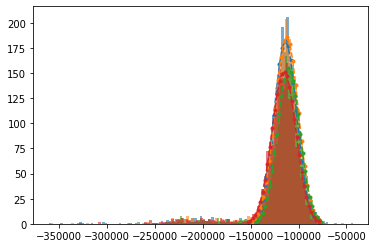

In [66]:
dataA1pe = get1peValue(readBufferA)
dataC1pe = get1peValue(readBufferC)
dataE1pe = get1peValue(readBufferE)
dataG1pe = get1peValue(readBufferG)

for chData, chName in zip([dataA1pe, dataC1pe, dataE1pe, dataG1pe], ["A", "C", "E", "G"]):
	hist, bins, histPatches = plt.hist(chData, bins=100, density=False, alpha=0.6)
	xbins = (bins[1:] + bins[:-1]) / 2.

	gmodel = GaussianModel()
	midGuess = np.average(xbins, weights=hist)
	stdGuess = np.sqrt(np.average((xbins - midGuess)**2, weights=hist))
	params = gmodel.make_params(amplitude=1, center=midGuess, sigma=stdGuess)
	result = gmodel.fit(hist, params, x=xbins)

	lowerbound = result.params["center"] - 3 * result.params["sigma"]
	upperbound = result.params["center"] + 3 * result.params["sigma"]
	mask = np.logical_and.reduce([xbins > lowerbound, xbins < upperbound])

	gmodel2 = GaussianModel()
	params2 = gmodel.make_params(amplitude=result.params["amplitude"], center=result.params["center"], sigma=result.params["sigma"])
	result2 = gmodel.fit(hist[mask], params, x=xbins[mask])

	plt.plot(xbins[mask], result2.best_fit, ".--", color=histPatches[0].get_fc()[:3])

	print("Channel {} 1 p.e.\n\tvalue\t{} \n\tstd\t {}".format(chName, result2.params["center"], result2.params["sigma"]))

    
plt.show()


# 1.5 pe trigger, 1 million events list creation (09:10 20.10 calib)

In [35]:
chA_ly=[]
chC_ly=[]
chE_ly=[]
chG_ly=[]

peCal_A=-111809.88211824221*adc_to_50mv
peCal_C=-111598.35392941294*adc_to_50mv
peCal_E=-107606.46117514349*adc_to_50mv
peCal_G=-113790.47385015768*adc_to_50mv



#nWaveforms = 2000
#maxsamples = 1500

nWaveforms = 10000
maxsamples = 3000


filepath = "/home/iwsatlas1/popov/NAS_futDet/DESY_Timing_Study/AHCAL/run3/Bulk{}-Ch{}-wf{}-{}.bin"

loops=100
nWaveforms = 10000
maxsamples = 3000

averages = np.zeros(nWaveforms)
segFrom = 0
segTo = nWaveforms-1

startTime=time.time()
for loop in range(loops):

    # Read DataFrames
	bufferType = ctypes.c_int16 * maxsamples

	readBufferA = np.zeros((nWaveforms, maxsamples), dtype=np.int16)

	with open(filepath.format(loop, "A", segFrom, segTo), "rb") as file:
		for i in range(nWaveforms):
			content = file.read(ctypes.sizeof(bufferType))
			pointer = ctypes.cast(content, ctypes.POINTER(bufferType))
			readBufferA[i, :] = np.asarray(pointer.contents)

	readBufferC = np.zeros((nWaveforms, maxsamples), dtype=np.int16)

	with open(filepath.format(loop, "C", segFrom, segTo), "rb") as file:
		for i in range(nWaveforms):
			content = file.read(ctypes.sizeof(bufferType))
			pointer = ctypes.cast(content, ctypes.POINTER(bufferType))
			readBufferC[i, :] = np.asarray(pointer.contents)

	
	readBufferE = np.zeros((nWaveforms, maxsamples), dtype=np.int16)

	with open(filepath.format(loop, "E", segFrom, segTo), "rb") as file:
		for i in range(nWaveforms):
			content = file.read(ctypes.sizeof(bufferType))
			pointer = ctypes.cast(content, ctypes.POINTER(bufferType))
			readBufferE[i, :] = np.asarray(pointer.contents)

	readBufferG = np.zeros((nWaveforms, maxsamples), dtype=np.int16)

	with open(filepath.format(loop, "G", segFrom, segTo), "rb") as file:
		for i in range(nWaveforms):
			content = file.read(ctypes.sizeof(bufferType))
			pointer = ctypes.cast(content, ctypes.POINTER(bufferType))
			readBufferG[i, :] = np.asarray(pointer.contents)
	time1=time.time()-startTime
	#print('{:.4f} : time to be done with data read'.format(time1))
	dataAsum = getIntegralCorr(readBufferA)/peCal_A 
	chA_ly.append(dataAsum)
	time2=time.time()-startTime
	#print('{:.4f}: done with first channel write'.format(time2))
	dataCsum = getIntegralCorr(readBufferC)/peCal_C 
	chC_ly.append(dataCsum)
	time3=time.time()-startTime
	#print('{:.4f}: done with second channel write'.format(time3))
	dataEsum = getIntegralCorr(readBufferE)/peCal_E
	chE_ly.append(dataEsum)
	dataGsum = getIntegralCorr(readBufferG)/peCal_G 
	chG_ly.append(dataGsum)
	print(loop)    

time4=time.time()-startTime
#print('{:.4f}: done with all reading'.format(time4))      
chA_ly_fin_1pe = []
for sublist in chA_ly:
    for item in sublist:
        chA_ly_fin_1pe.append(item)

chC_ly_fin_1pe = []
for sublist in chC_ly:
    for item in sublist:
        chC_ly_fin_1pe.append(item)

chE_ly_fin_1pe = []
for sublist in chE_ly:
    for item in sublist:
        chE_ly_fin_1pe.append(item)
        
chG_ly_fin_1pe = []
for sublist in chG_ly:
    for item in sublist:
        chG_ly_fin_1pe.append(item)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


# Histograms for 1.5pe trigger old calib

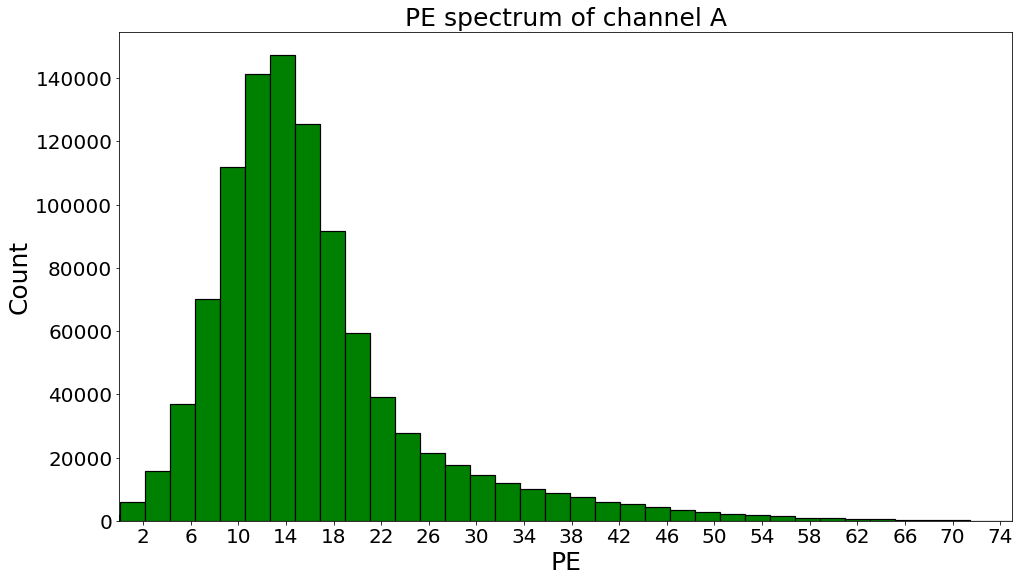

In [6]:
fig = plt.figure(figsize=(16,9)); 
ax10 = fig.add_subplot(1, 1, 1)
plt.hist(chA_ly_fin, bins=500, color='green', edgecolor='black', histtype='bar', linewidth=1.2, label='ChA PE distribution')
plt.xticks(np.arange(min(chA_ly_fin), max(chA_ly_fin)+1, 4.0))
ax10.set_ylabel('Count', fontsize=25)
ax10.set_xlabel('PE', fontsize=25)
ax10.set_title('PE spectrum of channel A', fontsize=25)  
ax10.tick_params(axis='x', labelsize=20 )
ax10.tick_params(axis='y', labelsize=20 )
ax10.set_xlim(0, 75)
#plt.legend(loc='upper right', prop={"size":20})
#plt.axis([-27, 0, 0, 14])
plt.savefig('/home/iwsatlas1/popov/Workspace/DESY_October2020/chA_1.5peTriggerSpectrum.pdf')

plt.show()

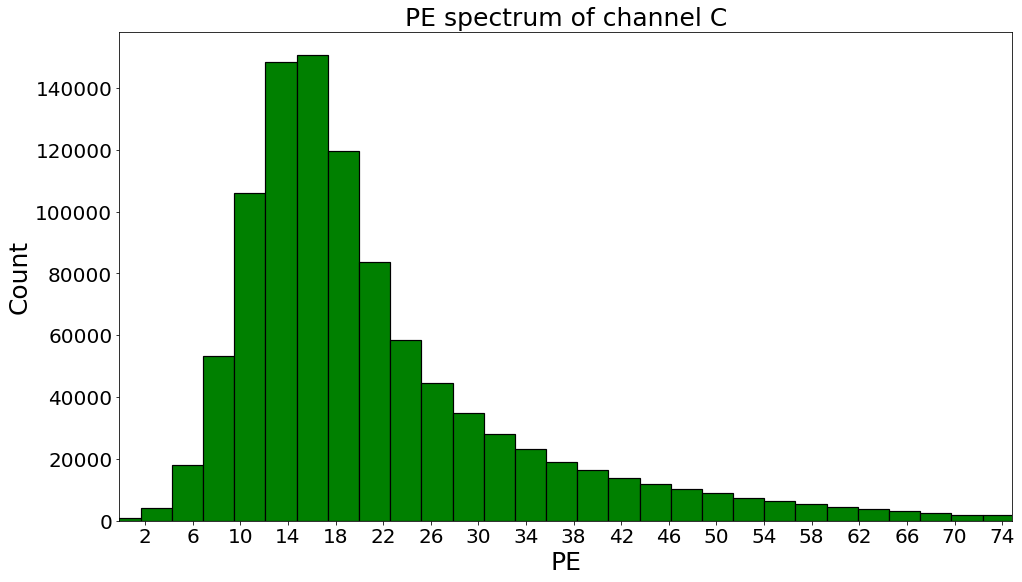

In [7]:
#print(chA_ly_fin)

fig = plt.figure(figsize=(16,9)); 
ax10 = fig.add_subplot(1, 1, 1)
plt.hist(chC_ly_fin, bins=500, color='green', edgecolor='black', histtype='bar', linewidth=1.2, label='ChC PE distribution')
plt.xticks(np.arange(min(chC_ly_fin), max(chC_ly_fin)+1, 4.0))
ax10.set_ylabel('Count', fontsize=25)
ax10.set_xlabel('PE', fontsize=25)
ax10.set_title('PE spectrum of channel C', fontsize=25)  
ax10.tick_params(axis='x', labelsize=20 )
ax10.tick_params(axis='y', labelsize=20 )
ax10.set_xlim(0, 75)
#plt.legend(loc='upper left', prop={"size":20})
#plt.axis([-27, 0, 0, 14])
plt.savefig('/home/iwsatlas1/popov/Workspace/DESY_October2020/chC_1.5peTriggerSpectrum.pdf')

plt.show()

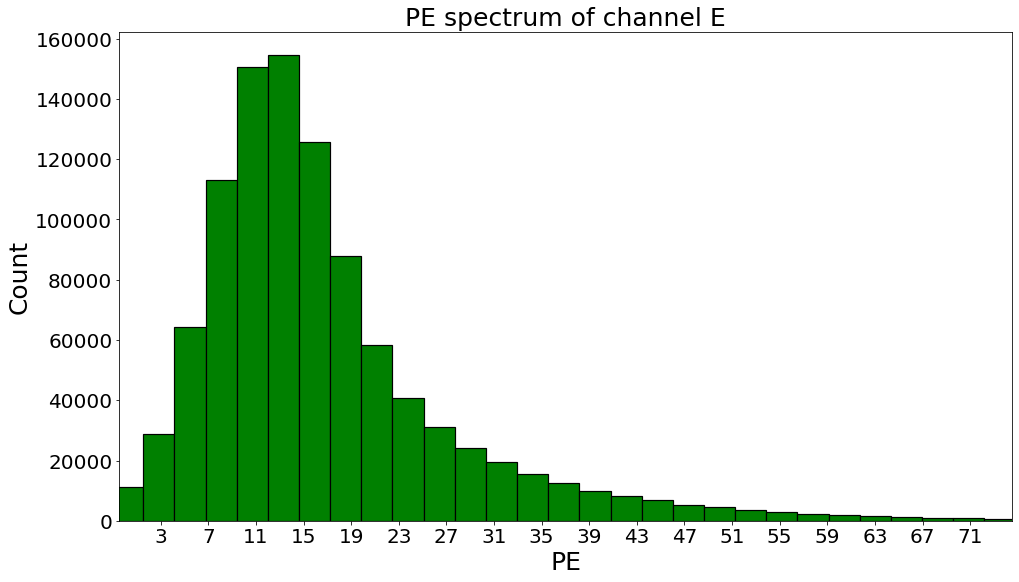

In [8]:
#print(chA_ly_fin)

fig = plt.figure(figsize=(16,9)); 
ax10 = fig.add_subplot(1, 1, 1)
plt.hist(chE_ly_fin, bins=500, color='green', edgecolor='black', histtype='bar', linewidth=1.2, label='ChE PE distribution')
plt.xticks(np.arange(min(chE_ly_fin), max(chE_ly_fin)+1, 4.0))
ax10.set_ylabel('Count', fontsize=25)
ax10.set_xlabel('PE', fontsize=25)
ax10.set_title('PE spectrum of channel E', fontsize=25)  
ax10.tick_params(axis='x', labelsize=20 )
ax10.tick_params(axis='y', labelsize=20 )
ax10.set_xlim(0, 75)
#plt.legend(loc='upper left', prop={"size":20})
#plt.axis([-27, 0, 0, 14])
plt.savefig('/home/iwsatlas1/popov/Workspace/DESY_October2020/chE_1.5peTriggerSpectrum.pdf')

plt.show()

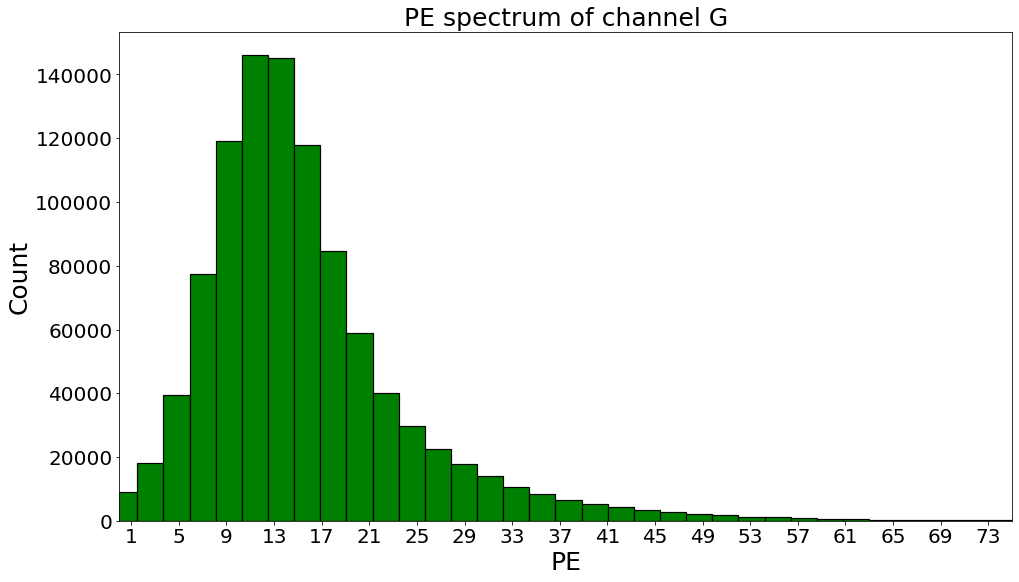

In [9]:
#print(chA_ly_fin)

fig = plt.figure(figsize=(16,9)); 
ax10 = fig.add_subplot(1, 1, 1)
plt.hist(chG_ly_fin, bins=300, color='green', edgecolor='black', histtype='bar', linewidth=1.2, label='ChG PE distribution')
plt.xticks(np.arange(min(chG_ly_fin), max(chG_ly_fin)+1, 4.0))
ax10.set_ylabel('Count', fontsize=25)
ax10.set_xlabel('PE', fontsize=25)
ax10.set_title('PE spectrum of channel G', fontsize=25)  
ax10.tick_params(axis='x', labelsize=20 )
ax10.tick_params(axis='y', labelsize=20 )
ax10.set_xlim(0, 75)
#plt.legend(loc='upper left', prop={"size":20})
#plt.axis([-27, 0, 0, 14])
plt.savefig('/home/iwsatlas1/popov/Workspace/DESY_October2020/chG_1.5peTriggerSpectrum.pdf')

plt.show()

# 2.5 pe trigger, 1 mil events, list creation (09:10 20.10 calib)

In [18]:
chA_ly=[]
chC_ly=[]
chE_ly=[]
chG_ly=[]

peCal_A=-111809.88211824221*adc_to_50mv
peCal_C=-111598.35392941294*adc_to_50mv
peCal_E=-107606.46117514349*adc_to_50mv
peCal_G=-113790.47385015768*adc_to_50mv



#nWaveforms = 2000
#maxsamples = 1500

nWaveforms = 10000
maxsamples = 3000


filepath = "/home/iwsatlas1/popov/NAS_futDet/DESY_Timing_Study/AHCAL/run2/Bulk{}-Ch{}-wf{}-{}.bin"

loops=100
nWaveforms = 10000
maxsamples = 3000

averages = np.zeros(nWaveforms)
segFrom = 0
segTo = nWaveforms-1

startTime=time.time()
for loop in range(loops):

    # Read DataFrames
	bufferType = ctypes.c_int16 * maxsamples

	readBufferA = np.zeros((nWaveforms, maxsamples), dtype=np.int16)

	with open(filepath.format(loop, "A", segFrom, segTo), "rb") as file:
		for i in range(nWaveforms):
			content = file.read(ctypes.sizeof(bufferType))
			pointer = ctypes.cast(content, ctypes.POINTER(bufferType))
			readBufferA[i, :] = np.asarray(pointer.contents)

	readBufferC = np.zeros((nWaveforms, maxsamples), dtype=np.int16)

	with open(filepath.format(loop, "C", segFrom, segTo), "rb") as file:
		for i in range(nWaveforms):
			content = file.read(ctypes.sizeof(bufferType))
			pointer = ctypes.cast(content, ctypes.POINTER(bufferType))
			readBufferC[i, :] = np.asarray(pointer.contents)

	
	readBufferE = np.zeros((nWaveforms, maxsamples), dtype=np.int16)

	with open(filepath.format(loop, "E", segFrom, segTo), "rb") as file:
		for i in range(nWaveforms):
			content = file.read(ctypes.sizeof(bufferType))
			pointer = ctypes.cast(content, ctypes.POINTER(bufferType))
			readBufferE[i, :] = np.asarray(pointer.contents)

	readBufferG = np.zeros((nWaveforms, maxsamples), dtype=np.int16)

	with open(filepath.format(loop, "G", segFrom, segTo), "rb") as file:
		for i in range(nWaveforms):
			content = file.read(ctypes.sizeof(bufferType))
			pointer = ctypes.cast(content, ctypes.POINTER(bufferType))
			readBufferG[i, :] = np.asarray(pointer.contents)
	time1=time.time()-startTime
	#print('{:.4f} : time to be done with data read'.format(time1))
	dataAsum = getIntegralCorr(readBufferA)/peCal_A 
	chA_ly.append(dataAsum)
	time2=time.time()-startTime
	#print('{:.4f}: done with first channel write'.format(time2))
	dataCsum = getIntegralCorr(readBufferC)/peCal_C 
	chC_ly.append(dataCsum)
	time3=time.time()-startTime
	#print('{:.4f}: done with second channel write'.format(time3))
	dataEsum = getIntegralCorr(readBufferE)/peCal_E
	chE_ly.append(dataEsum)
	dataGsum = getIntegralCorr(readBufferG)/peCal_G 
	chG_ly.append(dataGsum)
	print(loop)
time4=time.time()-startTime
#print('{:.4f}: done with all reading'.format(time4))      
chA_ly_fin = []
for sublist in chA_ly:
    for item in sublist:
        chA_ly_fin.append(item)

chC_ly_fin = []
for sublist in chC_ly:
    for item in sublist:
        chC_ly_fin.append(item)

chE_ly_fin = []
for sublist in chE_ly:
    for item in sublist:
        chE_ly_fin.append(item)
        
chG_ly_fin = []
for sublist in chG_ly:
    for item in sublist:
        chG_ly_fin.append(item)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


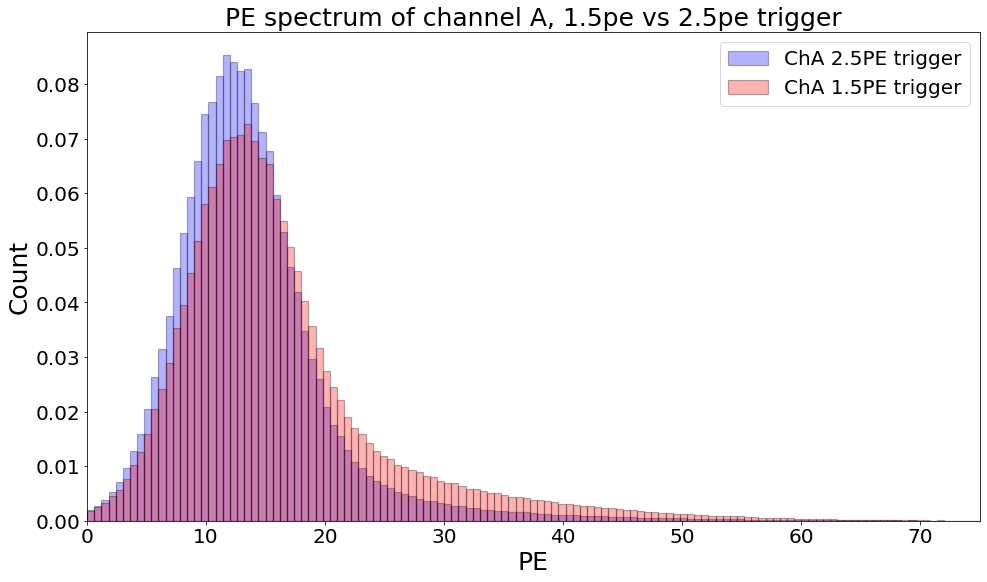

In [57]:
fig = plt.figure(figsize=(16,9)); 
ax10 = fig.add_subplot(1, 1, 1)

plt.hist(chA_ly_fin,range=[0,75], bins=125, alpha=0.3, color='blue', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChA 2.5PE trigger')
plt.hist(chA_ly_fin_1pe,range=[0,75], bins=125, alpha=0.3, color='red', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChA 1.5PE trigger')

#plt.xticks(np.arange(min(chA_ly_fin), max(chA_ly_fin)+1, 4.0))
ax10.set_ylabel('Count', fontsize=25)
ax10.set_xlabel('PE', fontsize=25)
ax10.set_title('PE spectrum of channel A, 1.5pe vs 2.5pe trigger', fontsize=25)  
ax10.tick_params(axis='x', labelsize=20 )
ax10.tick_params(axis='y', labelsize=20 )
ax10.set_xlim(0, 75)
plt.legend(loc='upper right', prop={"size":20})
#plt.axis([-27, 0, 0, 14])
#plt.savefig('/home/iwsatlas1/popov/Workspace/DESY_October2020/chA_2.5peTriggerSpectrum.pdf')

plt.show()

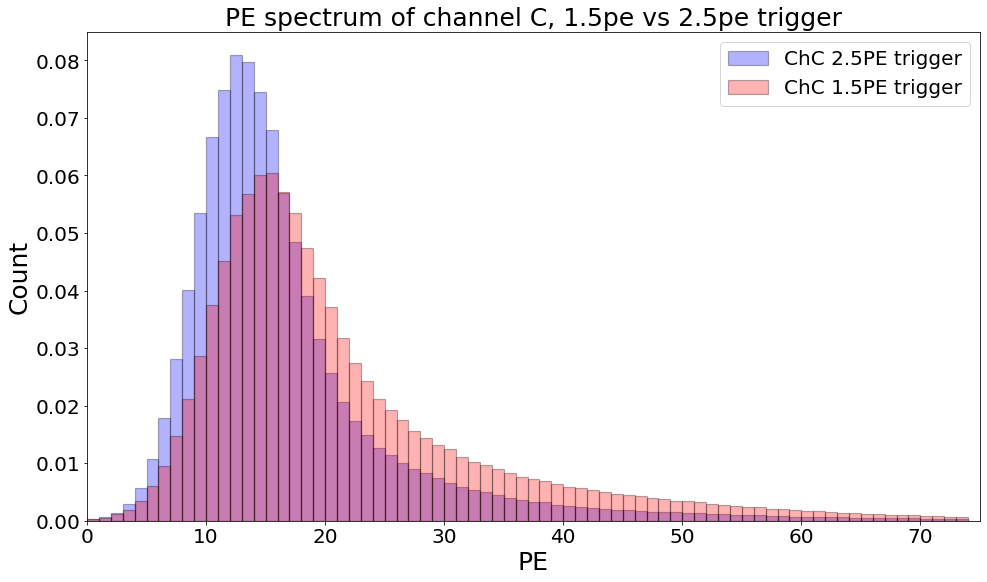

In [52]:
fig = plt.figure(figsize=(16,9)); 
ax10 = fig.add_subplot(1, 1, 1)
plt.hist(chC_ly_fin, bins=range(0,75), alpha=0.3, color='blue', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChC 2.5PE trigger')
plt.hist(chC_ly_fin_1pe, bins=range(0,75), alpha=0.3, color='red', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChC 1.5PE trigger')

#plt.xticks(np.arange(min(chC_ly_fin), max(chC_ly_fin)+1, 4.0))
ax10.set_ylabel('Count', fontsize=25)
ax10.set_xlabel('PE', fontsize=25)
ax10.set_title('PE spectrum of channel C, 1.5pe vs 2.5pe trigger', fontsize=25)  
ax10.tick_params(axis='x', labelsize=20 )
ax10.tick_params(axis='y', labelsize=20 )
ax10.set_xlim(0, 75)
plt.legend(loc='upper right', prop={"size":20})
#plt.axis([-27, 0, 0, 14])
#plt.savefig('/home/iwsatlas1/popov/Workspace/DESY_October2020/chC_2.5peTriggerSpectrum.pdf')

plt.show()

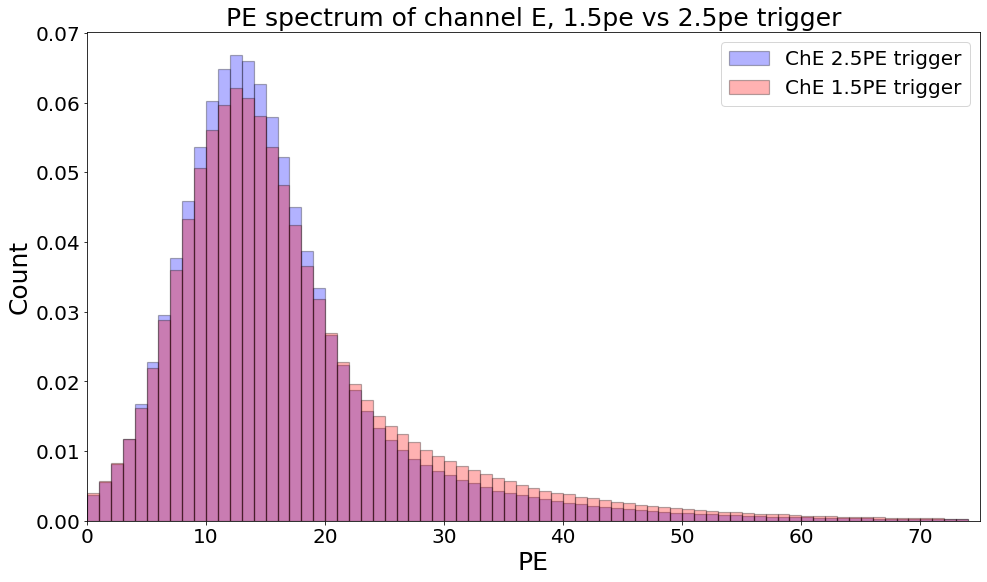

In [51]:
fig = plt.figure(figsize=(16,9)); 
ax10 = fig.add_subplot(1, 1, 1)
plt.hist(chE_ly_fin, bins=range(0,75), alpha=0.3, color='blue', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChE 2.5PE trigger')
plt.hist(chE_ly_fin_1pe, bins=range(0,75), alpha=0.3, color='red', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChE 1.5PE trigger')
#plt.xticks(np.arange(min(chE_ly_fin), max(chE_ly_fin)+1, 4.0))
ax10.set_ylabel('Count', fontsize=25)
ax10.set_xlabel('PE', fontsize=25)
ax10.set_title('PE spectrum of channel E, 1.5pe vs 2.5pe trigger', fontsize=25)  
ax10.tick_params(axis='x', labelsize=20 )
ax10.tick_params(axis='y', labelsize=20 )
ax10.set_xlim(0, 75)
plt.legend(loc='upper right', prop={"size":20})
#plt.axis([-27, 0, 0, 14])
#plt.savefig('/home/iwsatlas1/popov/Workspace/DESY_October2020/chE_2.5peTriggerSpectrum.pdf')

plt.show()

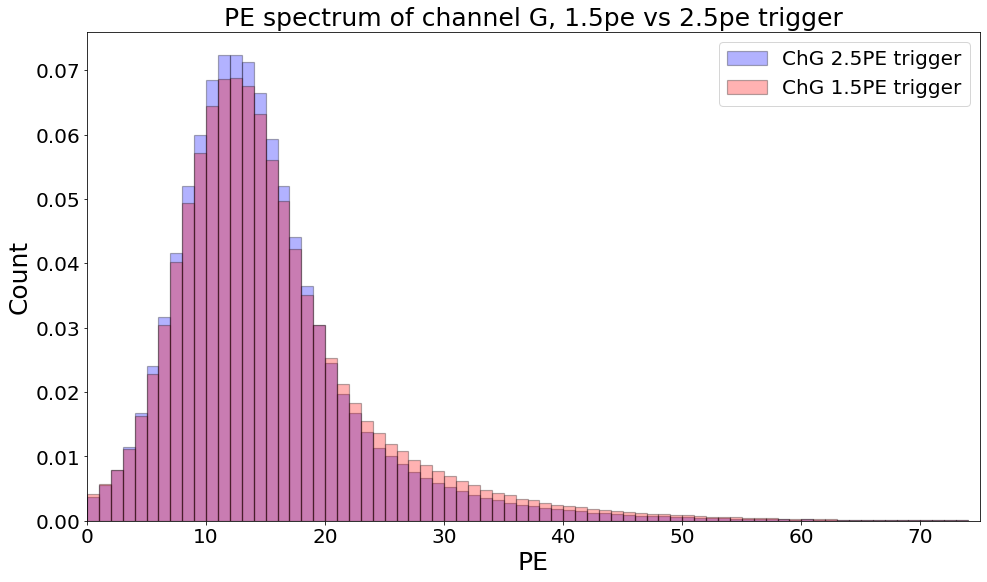

In [50]:
fig = plt.figure(figsize=(16,9)); 
ax10 = fig.add_subplot(1, 1, 1)
plt.hist(chG_ly_fin, bins=range(0,75), alpha=0.3, color='blue', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChG 2.5PE trigger')
plt.hist(chG_ly_fin_1pe, bins=range(0,75), alpha=0.3, color='red', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChG 1.5PE trigger')
#plt.xticks(np.arange(min(chG_ly_fin)-0.3, max(chG_ly_fin)+1, 4.0))
ax10.set_ylabel('Count', fontsize=25)
ax10.set_xlabel('PE', fontsize=25)
ax10.set_title('PE spectrum of channel G, 1.5pe vs 2.5pe trigger', fontsize=25)  
ax10.tick_params(axis='x', labelsize=20 )
ax10.tick_params(axis='y', labelsize=20 )
ax10.set_xlim(0, 75)
plt.legend(loc='upper right', prop={"size":20})
#plt.axis([-27, 0, 0, 14])
#plt.savefig('/home/iwsatlas1/popov/Workspace/DESY_October2020/chG_2.5peTriggerSpectrum.pdf')

plt.show()

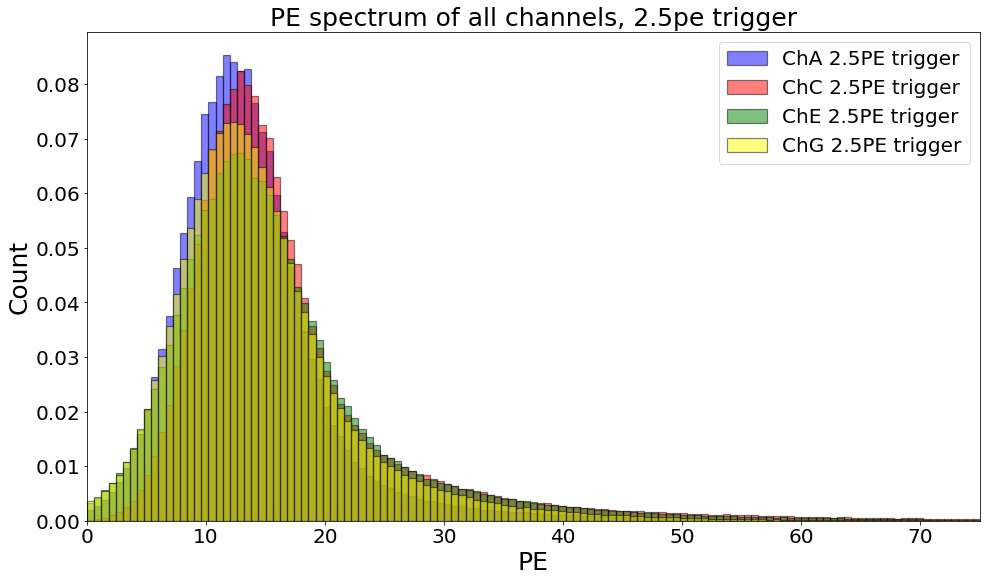

In [59]:
fig = plt.figure(figsize=(16,9)); 
ax10 = fig.add_subplot(1, 1, 1)
plt.hist(chA_ly_fin, range=[0,75], bins=125, alpha=0.5, color='blue', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChA 2.5PE trigger')
plt.hist(chC_ly_fin, range=[0,75], bins=125, alpha=0.5, color='red', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChC 2.5PE trigger')
plt.hist(chE_ly_fin, range=[0,75], bins=125, alpha=0.5, color='green', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChE 2.5PE trigger')
plt.hist(chG_ly_fin, range=[0,75], bins=125, alpha=0.5, color='yellow', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChG 2.5PE trigger')

#plt.xticks(np.arange(min(chE_ly_fin), max(chE_ly_fin)+1, 4.0))
ax10.set_ylabel('Count', fontsize=25)
ax10.set_xlabel('PE', fontsize=25)
ax10.set_title('PE spectrum of all channels, 2.5pe trigger', fontsize=25)  
ax10.tick_params(axis='x', labelsize=20 )
ax10.tick_params(axis='y', labelsize=20 )
ax10.set_xlim(0, 75)
plt.legend(loc='upper right', prop={"size":20})
#plt.axis([-27, 0, 0, 14])
#plt.savefig('/home/iwsatlas1/popov/Workspace/DESY_October2020/chE_2.5peTriggerSpectrum.pdf')

plt.show()

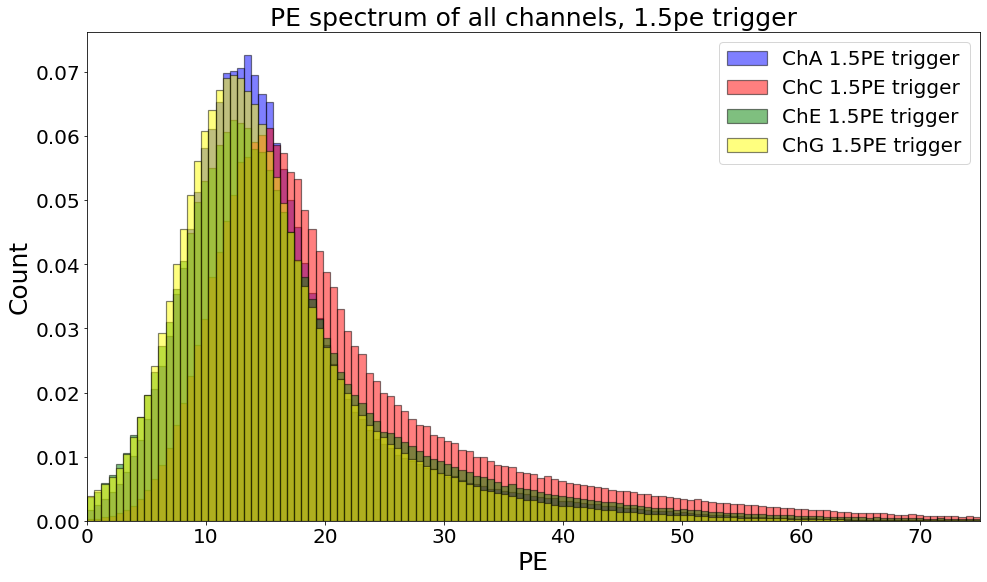

In [60]:
fig = plt.figure(figsize=(16,9)); 
ax10 = fig.add_subplot(1, 1, 1)
plt.hist(chA_ly_fin_1pe, range=[0,75], bins=125, alpha=0.5, color='blue', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChA 1.5PE trigger')
plt.hist(chC_ly_fin_1pe, range=[0,75], bins=125, alpha=0.5, color='red', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChC 1.5PE trigger')
plt.hist(chE_ly_fin_1pe, range=[0,75], bins=125, alpha=0.5, color='green', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChE 1.5PE trigger')
plt.hist(chG_ly_fin_1pe, range=[0,75], bins=125, alpha=0.5, color='yellow', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChG 1.5PE trigger')

#plt.xticks(np.arange(min(chE_ly_fin), max(chE_ly_fin)+1, 4.0))
ax10.set_ylabel('Count', fontsize=25)
ax10.set_xlabel('PE', fontsize=25)
ax10.set_title('PE spectrum of all channels, 1.5pe trigger', fontsize=25)  
ax10.tick_params(axis='x', labelsize=20 )
ax10.tick_params(axis='y', labelsize=20 )
ax10.set_xlim(0, 75)
plt.legend(loc='upper right', prop={"size":20})
#plt.axis([-27, 0, 0, 14])
#plt.savefig('/home/iwsatlas1/popov/Workspace/DESY_October2020/chE_2.5peTriggerSpectrum.pdf')

plt.show()

# 1pe & 2pe Cal from 19:10, 19.10

In [115]:
chA_ly_fin_v2 = []
chC_ly_fin_v2 = [] 
chE_ly_fin_v2 = []
chG_ly_fin_v2 = []


for i in chA_ly_fin:
    chA_ly_fin_v2.append(i*-111809.88211824221/-113748.33381927326)

for i in chC_ly_fin:
    chC_ly_fin_v2.append(i*-111598.35392941294/-112436.22842876363)

for i in chE_ly_fin:
    chE_ly_fin_v2.append(i*-107606.46117514349/-110472.18140823225)
    
for i in chG_ly_fin:
    chG_ly_fin_v2.append(i*-113790.47385015768/-115203.5108329922)
    
chA_ly_fin_1pe_v2 = []
chC_ly_fin_1pe_v2 = []
chE_ly_fin_1pe_v2 = []
chG_ly_fin_1pe_v2 = []

for i in chA_ly_fin_1pe:
    chA_ly_fin_1pe_v2.append(i*-111809.88211824221/-113748.33381927326)

for i in chC_ly_fin_1pe:
    chC_ly_fin_1pe_v2.append(i*-111598.35392941294/-112436.22842876363)

for i in chE_ly_fin_1pe:
    chE_ly_fin_1pe_v2.append(i*-107606.46117514349/-110472.18140823225)
    
for i in chG_ly_fin_1pe:
    chG_ly_fin_1pe_v2.append(i*-113790.47385015768/-115203.5108329922)


7.158818625890256
7.036821022261372


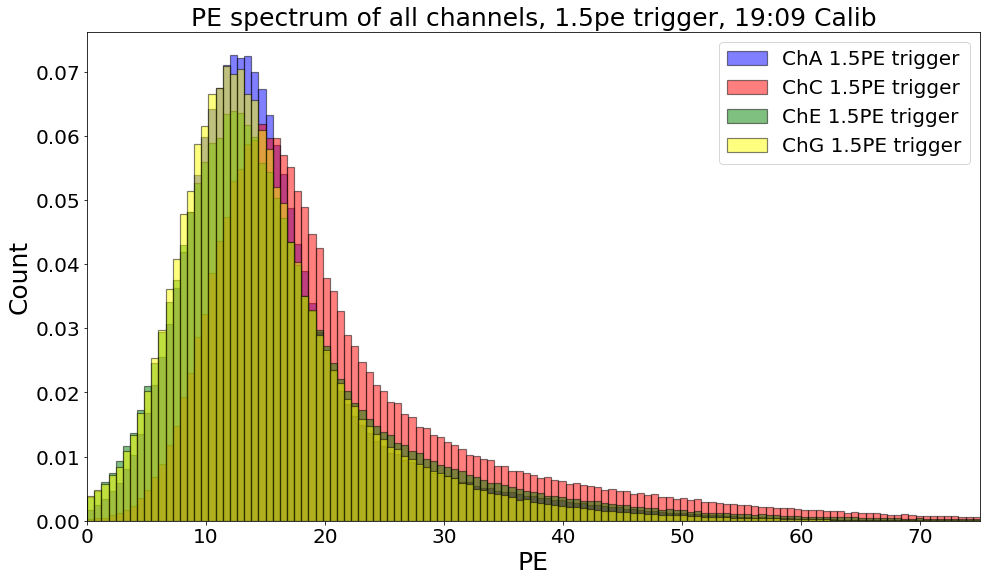

In [112]:
fig = plt.figure(figsize=(16,9)); 
ax10 = fig.add_subplot(1, 1, 1)
plt.hist(chA_ly_fin_1pe_v2, range=[0,75], bins=125, alpha=0.5, color='blue', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChA 1.5PE trigger')
plt.hist(chC_ly_fin_1pe_v2, range=[0,75], bins=125, alpha=0.5, color='red', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChC 1.5PE trigger')
plt.hist(chE_ly_fin_1pe_v2, range=[0,75], bins=125, alpha=0.5, color='green', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChE 1.5PE trigger')
plt.hist(chG_ly_fin_1pe_v2, range=[0,75], bins=125, alpha=0.5, color='yellow', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChG 1.5PE trigger')

#plt.xticks(np.arange(min(chE_ly_fin), max(chE_ly_fin)+1, 4.0))
ax10.set_ylabel('Count', fontsize=25)
ax10.set_xlabel('PE', fontsize=25)
ax10.set_title('PE spectrum of all channels, 1.5pe trigger, 19:09 Calib', fontsize=25)  
ax10.tick_params(axis='x', labelsize=20 )
ax10.tick_params(axis='y', labelsize=20 )
ax10.set_xlim(0, 75)
plt.legend(loc='upper right', prop={"size":20})
#plt.axis([-27, 0, 0, 14])
#plt.savefig('/home/iwsatlas1/popov/Workspace/DESY_October2020/chE_2.5peTriggerSpectrum.pdf')

plt.show()

# Gaussian fit (9:10 20.10 calib), 1.5pe trigger

Channel A 1 p.e.
	value	<Parameter 'center', value=13.119215556604773 +/- 0.0331, bounds=[-inf:inf]> 
	std	 <Parameter 'sigma', value=4.712683758169355 +/- 0.0596, bounds=[0:inf]>


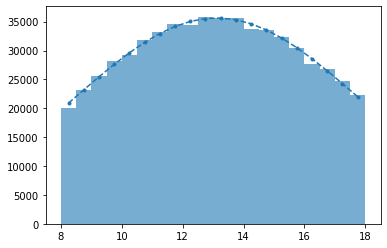

In [84]:
hist, bins, histPatches = plt.hist(chA_ly_fin_1pe, range=[8,18], bins=20, density=False, alpha=0.6)
xbins = (bins[1:] + bins[:-1]) / 2.

gmodel = GaussianModel()
midGuess = np.average(xbins, weights=hist)
stdGuess = np.sqrt(np.average((xbins - midGuess)**2, weights=hist))
params = gmodel.make_params(amplitude=1, center=midGuess, sigma=stdGuess)
result = gmodel.fit(hist, params, x=xbins)

lowerbound = result.params["center"] - 3 * result.params["sigma"]
upperbound = result.params["center"] + 3 * result.params["sigma"]
mask = np.logical_and.reduce([xbins > lowerbound, xbins < upperbound])

gmodel2 = GaussianModel()
params2 = gmodel.make_params(amplitude=result.params["amplitude"], center=result.params["center"], sigma=result.params["sigma"])
result2 = gmodel.fit(hist[mask], params, x=xbins[mask])

plt.plot(xbins[mask], result2.best_fit, ".--", color=histPatches[0].get_fc()[:3])

print("Channel A 1 p.e.\n\tvalue\t{} \n\tstd\t {}".format(result2.params["center"], result2.params["sigma"]))

    
plt.show()

Channel C 1 p.e.
	value	<Parameter 'center', value=15.192414897056208 +/- 0.0473, bounds=[-inf:inf]> 
	std	 <Parameter 'sigma', value=4.91550706761078 +/- 0.0883, bounds=[0:inf]>


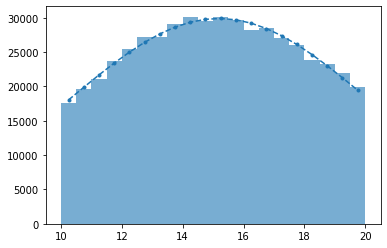

In [86]:
hist, bins, histPatches = plt.hist(chC_ly_fin_1pe, range=[10,20], bins=20, density=False, alpha=0.6)
xbins = (bins[1:] + bins[:-1]) / 2.

gmodel = GaussianModel()
midGuess = np.average(xbins, weights=hist)
stdGuess = np.sqrt(np.average((xbins - midGuess)**2, weights=hist))
params = gmodel.make_params(amplitude=1, center=midGuess, sigma=stdGuess)
result = gmodel.fit(hist, params, x=xbins)

lowerbound = result.params["center"] - 3 * result.params["sigma"]
upperbound = result.params["center"] + 3 * result.params["sigma"]
mask = np.logical_and.reduce([xbins > lowerbound, xbins < upperbound])

gmodel2 = GaussianModel()
params2 = gmodel.make_params(amplitude=result.params["amplitude"], center=result.params["center"], sigma=result.params["sigma"])
result2 = gmodel.fit(hist[mask], params, x=xbins[mask])

plt.plot(xbins[mask], result2.best_fit, ".--", color=histPatches[0].get_fc()[:3])

print("Channel C 1 p.e.\n\tvalue\t{} \n\tstd\t {}".format(result2.params["center"], result2.params["sigma"]))

    
plt.show()

Channel E 1 p.e.
	value	<Parameter 'center', value=12.82707091430684 +/- 0.0467, bounds=[-inf:inf]> 
	std	 <Parameter 'sigma', value=5.262795431634657 +/- 0.0934, bounds=[0:inf]>


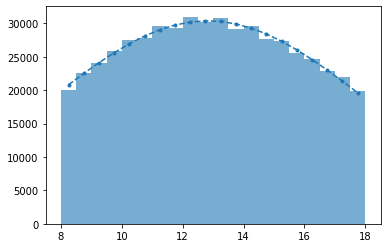

In [88]:
hist, bins, histPatches = plt.hist(chE_ly_fin_1pe, range=[8,18], bins=20, density=False, alpha=0.6)
xbins = (bins[1:] + bins[:-1]) / 2.

gmodel = GaussianModel()
midGuess = np.average(xbins, weights=hist)
stdGuess = np.sqrt(np.average((xbins - midGuess)**2, weights=hist))
params = gmodel.make_params(amplitude=1, center=midGuess, sigma=stdGuess)
result = gmodel.fit(hist, params, x=xbins)

lowerbound = result.params["center"] - 3 * result.params["sigma"]
upperbound = result.params["center"] + 3 * result.params["sigma"]
mask = np.logical_and.reduce([xbins > lowerbound, xbins < upperbound])

gmodel2 = GaussianModel()
params2 = gmodel.make_params(amplitude=result.params["amplitude"], center=result.params["center"], sigma=result.params["sigma"])
result2 = gmodel.fit(hist[mask], params, x=xbins[mask])

plt.plot(xbins[mask], result2.best_fit, ".--", color=histPatches[0].get_fc()[:3])

print("Channel E 1 p.e.\n\tvalue\t{} \n\tstd\t {}".format(result2.params["center"], result2.params["sigma"]))

    
plt.show()

Channel G 1 p.e.
	value	<Parameter 'center', value=12.48437926491403 +/- 0.045, bounds=[-inf:inf]> 
	std	 <Parameter 'sigma', value=4.847304443814988 +/- 0.0833, bounds=[0:inf]>


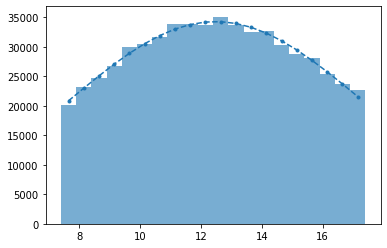

In [90]:
hist, bins, histPatches = plt.hist(chG_ly_fin_1pe, range=[7.4,17.4], bins=20, density=False, alpha=0.6)
xbins = (bins[1:] + bins[:-1]) / 2.

gmodel = GaussianModel()
midGuess = np.average(xbins, weights=hist)
stdGuess = np.sqrt(np.average((xbins - midGuess)**2, weights=hist))
params = gmodel.make_params(amplitude=1, center=midGuess, sigma=stdGuess)
result = gmodel.fit(hist, params, x=xbins)

lowerbound = result.params["center"] - 3 * result.params["sigma"]
upperbound = result.params["center"] + 3 * result.params["sigma"]
mask = np.logical_and.reduce([xbins > lowerbound, xbins < upperbound])

gmodel2 = GaussianModel()
params2 = gmodel.make_params(amplitude=result.params["amplitude"], center=result.params["center"], sigma=result.params["sigma"])
result2 = gmodel.fit(hist[mask], params, x=xbins[mask])

plt.plot(xbins[mask], result2.best_fit, ".--", color=histPatches[0].get_fc()[:3])

print("Channel G 1 p.e.\n\tvalue\t{} \n\tstd\t {}".format(result2.params["center"], result2.params["sigma"]))

    
plt.show()

# Gaussian Fit 2.5 pe trigger, 9:10 20.10 calib

Channel A 1 p.e.
	value	<Parameter 'center', value=12.300678927773074 +/- 0.0242, bounds=[-inf:inf]> 
	std	 <Parameter 'sigma', value=4.35625214050887 +/- 0.0404, bounds=[0:inf]>


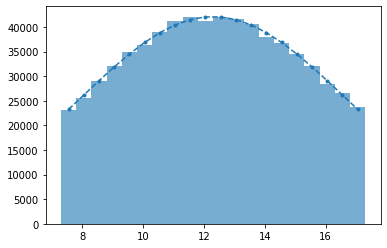

In [116]:
hist, bins, histPatches = plt.hist(chA_ly_fin, range=[7.3,17.3], bins=20, density=False, alpha=0.6)
xbins = (bins[1:] + bins[:-1]) / 2.

gmodel = GaussianModel()
midGuess = np.average(xbins, weights=hist)
stdGuess = np.sqrt(np.average((xbins - midGuess)**2, weights=hist))
params = gmodel.make_params(amplitude=1, center=midGuess, sigma=stdGuess)
result = gmodel.fit(hist, params, x=xbins)

lowerbound = result.params["center"] - 3 * result.params["sigma"]
upperbound = result.params["center"] + 3 * result.params["sigma"]
mask = np.logical_and.reduce([xbins > lowerbound, xbins < upperbound])

gmodel2 = GaussianModel()
params2 = gmodel.make_params(amplitude=result.params["amplitude"], center=result.params["center"], sigma=result.params["sigma"])
result2 = gmodel.fit(hist[mask], params, x=xbins[mask])

plt.plot(xbins[mask], result2.best_fit, ".--", color=histPatches[0].get_fc()[:3])

print("Channel A 1 p.e.\n\tvalue\t{} \n\tstd\t {}".format(result2.params["center"], result2.params["sigma"]))

    
plt.show()

Channel C 1 p.e.
	value	<Parameter 'center', value=13.172426663145773 +/- 0.045, bounds=[-inf:inf]> 
	std	 <Parameter 'sigma', value=4.124827155341441 +/- 0.0713, bounds=[0:inf]>


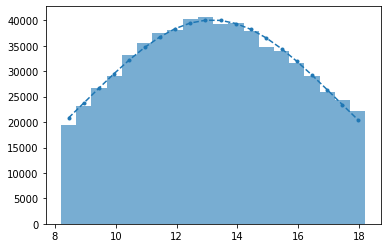

In [117]:
hist, bins, histPatches = plt.hist(chC_ly_fin, range=[8.2,18.2], bins=20, density=False, alpha=0.6)
xbins = (bins[1:] + bins[:-1]) / 2.

gmodel = GaussianModel()
midGuess = np.average(xbins, weights=hist)
stdGuess = np.sqrt(np.average((xbins - midGuess)**2, weights=hist))
params = gmodel.make_params(amplitude=1, center=midGuess, sigma=stdGuess)
result = gmodel.fit(hist, params, x=xbins)

lowerbound = result.params["center"] - 3 * result.params["sigma"]
upperbound = result.params["center"] + 3 * result.params["sigma"]
mask = np.logical_and.reduce([xbins > lowerbound, xbins < upperbound])

gmodel2 = GaussianModel()
params2 = gmodel.make_params(amplitude=result.params["amplitude"], center=result.params["center"], sigma=result.params["sigma"])
result2 = gmodel.fit(hist[mask], params, x=xbins[mask])

plt.plot(xbins[mask], result2.best_fit, ".--", color=histPatches[0].get_fc()[:3])

print("Channel C 1 p.e.\n\tvalue\t{} \n\tstd\t {}".format(result2.params["center"], result2.params["sigma"]))

    
plt.show()

Channel E 1 p.e.
	value	<Parameter 'center', value=12.88271008511922 +/- 0.0381, bounds=[-inf:inf]> 
	std	 <Parameter 'sigma', value=5.097504675175681 +/- 0.0741, bounds=[0:inf]>


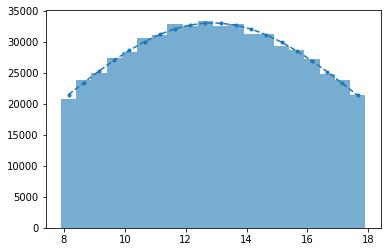

In [118]:
hist, bins, histPatches = plt.hist(chE_ly_fin, range=[7.9,17.9], bins=20, density=False, alpha=0.6)
xbins = (bins[1:] + bins[:-1]) / 2.

gmodel = GaussianModel()
midGuess = np.average(xbins, weights=hist)
stdGuess = np.sqrt(np.average((xbins - midGuess)**2, weights=hist))
params = gmodel.make_params(amplitude=1, center=midGuess, sigma=stdGuess)
result = gmodel.fit(hist, params, x=xbins)

lowerbound = result.params["center"] - 3 * result.params["sigma"]
upperbound = result.params["center"] + 3 * result.params["sigma"]
mask = np.logical_and.reduce([xbins > lowerbound, xbins < upperbound])

gmodel2 = GaussianModel()
params2 = gmodel.make_params(amplitude=result.params["amplitude"], center=result.params["center"], sigma=result.params["sigma"])
result2 = gmodel.fit(hist[mask], params, x=xbins[mask])

plt.plot(xbins[mask], result2.best_fit, ".--", color=histPatches[0].get_fc()[:3])

print("Channel E 1 p.e.\n\tvalue\t{} \n\tstd\t {}".format(result2.params["center"], result2.params["sigma"]))

    
plt.show()

Channel G 1 p.e.
	value	<Parameter 'center', value=12.477124295145503 +/- 0.0384, bounds=[-inf:inf]> 
	std	 <Parameter 'sigma', value=4.796063371536477 +/- 0.0705, bounds=[0:inf]>


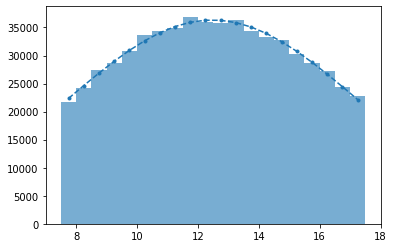

In [103]:
hist, bins, histPatches = plt.hist(chG_ly_fin, range=[7.5,17.5], bins=20, density=False, alpha=0.6)
xbins = (bins[1:] + bins[:-1]) / 2.

gmodel = GaussianModel()
midGuess = np.average(xbins, weights=hist)
stdGuess = np.sqrt(np.average((xbins - midGuess)**2, weights=hist))
params = gmodel.make_params(amplitude=1, center=midGuess, sigma=stdGuess)
result = gmodel.fit(hist, params, x=xbins)

lowerbound = result.params["center"] - 3 * result.params["sigma"]
upperbound = result.params["center"] + 3 * result.params["sigma"]
mask = np.logical_and.reduce([xbins > lowerbound, xbins < upperbound])

gmodel2 = GaussianModel()
params2 = gmodel.make_params(amplitude=result.params["amplitude"], center=result.params["center"], sigma=result.params["sigma"])
result2 = gmodel.fit(hist[mask], params, x=xbins[mask])

plt.plot(xbins[mask], result2.best_fit, ".--", color=histPatches[0].get_fc()[:3])

print("Channel G 1 p.e.\n\tvalue\t{} \n\tstd\t {}".format(result2.params["center"], result2.params["sigma"]))

    
plt.show()

# 1.5 & 2.5 pe trigger, 9:10 20.10 calib, pe to MIP scale adjustment

In [119]:
chA_ly_fin_mip=[] 
chC_ly_fin_mip=[]
chE_ly_fin_mip=[]
chG_ly_fin_mip=[]

for i in chA_ly_fin:
    chA_ly_fin_mip.append(i/12.300678927773074)

for i in chC_ly_fin:
    chC_ly_fin_mip.append(i/13.172426663145773)

for i in chE_ly_fin:
    chE_ly_fin_mip.append(i/12.88271008511922)
    
for i in chG_ly_fin:
    chG_ly_fin_mip.append(i/12.477124295145503)
    
chA_ly_fin_1pe_mip=[] 
chC_ly_fin_1pe_mip=[]
chE_ly_fin_1pe_mip=[]
chG_ly_fin_1pe_mip=[]

for i in chA_ly_fin_1pe:
    chA_ly_fin_1pe_mip.append(i/13.119215556604773)

for i in chC_ly_fin_1pe:
    chC_ly_fin_1pe_mip.append(i/15.192414897056208)

for i in chE_ly_fin_1pe:
    chE_ly_fin_1pe_mip.append(i/12.82707091430684)
    
for i in chG_ly_fin_1pe:
    chG_ly_fin_1pe_mip.append(i/12.48437926491403)
    

# 9:10 20.10 calib MIP hist

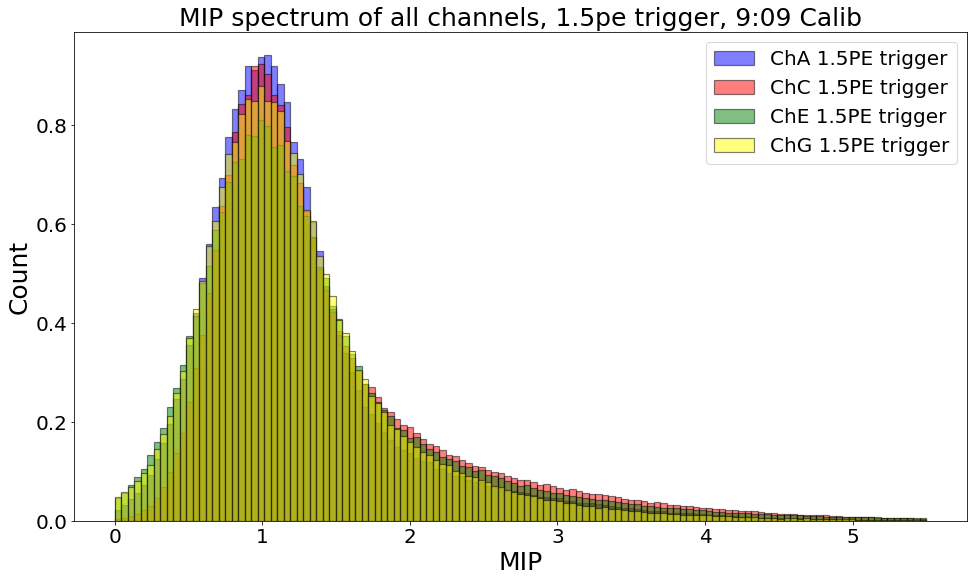

In [125]:
fig = plt.figure(figsize=(16,9)); 
ax10 = fig.add_subplot(1, 1, 1)
plt.hist(chA_ly_fin_1pe_mip, range=[0,5.5], bins=125, alpha=0.5, color='blue', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChA 1.5PE trigger')
plt.hist(chC_ly_fin_1pe_mip, range=[0,5.5], bins=125, alpha=0.5, color='red', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChC 1.5PE trigger')
plt.hist(chE_ly_fin_1pe_mip, range=[0,5.5], bins=125, alpha=0.5, color='green', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChE 1.5PE trigger')
plt.hist(chG_ly_fin_1pe_mip, range=[0,5.5], bins=125, alpha=0.5, color='yellow', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChG 1.5PE trigger')

#plt.xticks(np.arange(min(chE_ly_fin), max(chE_ly_fin)+1, 4.0))
ax10.set_ylabel('Count', fontsize=25)
ax10.set_xlabel('MIP', fontsize=25)
ax10.set_title('MIP spectrum of all channels, 1.5pe trigger, 9:09 Calib', fontsize=25)  
ax10.tick_params(axis='x', labelsize=20 )
ax10.tick_params(axis='y', labelsize=20 )
#ax10.set_xlim(-10, 80)
plt.legend(loc='upper right', prop={"size":20})
#plt.axis([-27, 0, 0, 14])
#plt.savefig('/home/iwsatlas1/popov/Workspace/DESY_October2020/chE_2.5peTriggerSpectrum.pdf')

plt.show()

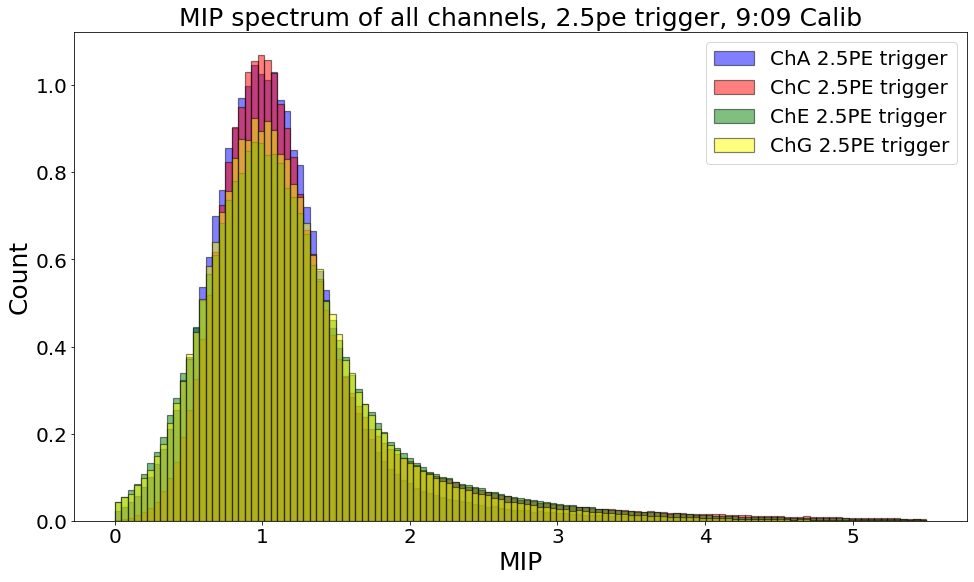

In [126]:
fig = plt.figure(figsize=(16,9)); 
ax10 = fig.add_subplot(1, 1, 1)
plt.hist(chA_ly_fin_mip, range=[0,5.5], bins=125, alpha=0.5, color='blue', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChA 2.5PE trigger')
plt.hist(chC_ly_fin_mip, range=[0,5.5], bins=125, alpha=0.5, color='red', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChC 2.5PE trigger')
plt.hist(chE_ly_fin_mip, range=[0,5.5], bins=125, alpha=0.5, color='green', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChE 2.5PE trigger')
plt.hist(chG_ly_fin_mip, range=[0,5.5], bins=125, alpha=0.5, color='yellow', density=True, edgecolor='black', histtype='bar', linewidth=1.2, label='ChG 2.5PE trigger')

#plt.xticks(np.arange(min(chE_ly_fin), max(chE_ly_fin)+1, 4.0))
ax10.set_ylabel('Count', fontsize=25)
ax10.set_xlabel('MIP', fontsize=25)
ax10.set_title('MIP spectrum of all channels, 2.5pe trigger, 9:09 Calib', fontsize=25)  
ax10.tick_params(axis='x', labelsize=20 )
ax10.tick_params(axis='y', labelsize=20 )
#ax10.set_xlim(-10, 80)
plt.legend(loc='upper right', prop={"size":20})
#plt.axis([-27, 0, 0, 14])
#plt.savefig('/home/iwsatlas1/popov/Workspace/DESY_October2020/chE_2.5peTriggerSpectrum.pdf')

plt.show()

# Langaus Fit

In [153]:
from langaus import LanGausFit
import langaus
import ROOT


In [164]:
hist = ROOT.TH1D("channelA", "channelAHist",100,0,5.5)
chA_array=np.array(chA_ly_fin_mip)

for i in chA_array:
    hist.Fill(i)
print(hist.GetMean())

value=ROOT.langaufun

fit = LanGausFit()
func = fit.fit(hist, fitrange=(0,5.5))


# for gain in p_dif.ConvGain.unique():
# #     plt.hist(df_psel.ADC,bins=np.arange(df_psel.ADC.min(),
#     df_psel.ADC.max(), 11))
#     df_psel = p_dif[p_dif.ConvGain==gain]
#     df_psel = df_psel.reset_index()
# #     print(df_psel)
#     nbins = int(len(df_psel)/20)


#     canvas1 = ROOT.TCanvas("canvas1","canvas1",800, 600)
#     canvas1.SetFillColor(0)
#     canvas1.SetGrid()
#     canvas1.GetFrame().SetFillColor(2)
#     canvas1.GetFrame().SetBorderSize(12)
#     if base_dir.find("Pos_19")>=0:
#         if gain == 2:    histLangaus = ROOT.TH1D("dataLangaus",
# "dataLangaus", 20, 0,200)
#         elif gain == 4:  histLangaus = ROOT.TH1D("dataLangaus",
# "dataLangaus", 20, 0,200)
#         elif gain == 8:  histLangaus = ROOT.TH1D("dataLangaus",
# "dataLangaus", 20, 0,400)
#         elif gain == 12: histLangaus = ROOT.TH1D("dataLangaus",
# "dataLangaus", 20, 0,600)
#         elif gain == 15: histLangaus = ROOT.TH1D("dataLangaus",
# "dataLangaus", 20, 0,1000)
#     else:
#         histLangaus = ROOT.TH1D("dataLangaus", "dataLangaus", 100,
# 0,df_psel.ADC.max())
#     histLangaus.SetLineColor(1)
#     for element in range(len(df_psel)):
#         histLangaus.Fill(df_psel[df_psel.index==element].ADC)

#     histLangaus.Draw()
#     histLangaus.SetAxisRange(0,df_psel.ADC.max())
#     if run_dir.find("_OV2V/") >=0:
#         if gain == 2:
#             histLangaus.SetAxisRange(0,200,"X")
#         elif gain == 4:
#             histLangaus.SetAxisRange(0,200,"X")
#         elif gain == 8:
#             histLangaus.SetAxisRange(80,300,"X")
#         elif gain == 12:
#             histLangaus.SetAxisRange(150,300,"X")
#         elif gain == 15:
#             histLangaus.SetAxisRange(130,400,"X")
#     else:
#         if gain == 2:
#             histLangaus.SetAxisRange(0,200,"X")
#         elif gain == 4:
#             histLangaus.SetAxisRange(0,200,"X")
#         elif gain == 8:
#             histLangaus.SetAxisRange(80,400,"X")
#         elif gain == 12:
#             histLangaus.SetAxisRange(150,600,"X")
#         elif gain == 15:
#             histLangaus.SetAxisRange(130,1000,"X")


#     if base_dir.find("_OV2V/") >=0:
#         if gain == 2:   histLangaus.SetAxisRange(0,100,"X")
#         elif gain == 4: histLangaus.SetAxisRange(0,100,"X")
#         elif gain == 8: histLangaus.SetAxisRange(0,200,"X")
#         elif gain == 12:histLangaus.SetAxisRange(0,300,"X")
#         elif gain == 15:histLangaus.SetAxisRange(0,400,"X")
#     else:
#         if gain == 2:   histLangaus.SetAxisRange(0,200,"X")
#         elif gain == 4: histLangaus.SetAxisRange(0,200,"X")
#         elif gain == 8: histLangaus.SetAxisRange(0,400,"X")
#         elif gain == 12:histLangaus.SetAxisRange(0,600,"X")
#         elif gain == 15:histLangaus.SetAxisRange(0,1000,"X")

#     histLangaus.GetXaxis().SetTitle("Reconstructed Amplitudes [ADC]")
#     histLangaus.GetYaxis().SetTitle("No. of entries")
#     histLangaus.GetXaxis().SetLabelSize(0.05);
#     histLangaus.GetXaxis().SetTitleSize(0.05);
#     histLangaus.GetXaxis().SetNdivisions(505);
#     histLangaus.GetXaxis().SetTitleOffset(1.0);
#     histLangaus.GetYaxis().SetTitleOffset(1.0);
#     histLangaus.GetYaxis().SetLabelSize(0.05);
#     histLangaus.GetYaxis().SetTitleSize(0.05);

#     fit = LanGausFit()
#     func = fit.fit(histLangaus,fitrange=(df_psel.ADC.mean()-2*df_psel.ADC.std(),df_psel.ADC.mean()+3*df_psel.ADC.std()))

#     wdth        = func.GetParameter(0)
#     wdth_err    = func.GetParError(0)
#     mpv         = func.GetParameter(1)
#     mpv_err     = func.GetParError(1)
#     norm        = func.GetParameter(2)
#     norm_err    = func.GetParError(2)
#     mu          = func.GetParameter(3)
#     mu_err      = func.GetParError(3)
#     mpv_lan     = func.GetMaximumX()
#     mpv_lan_err = (mpv_err/mpv)*(mpv_lan)
#      # mpv,mpv_lan

#     func.Draw("same")

#      ROOT.gStyle.SetOptTitle(0)
#      ROOT.gStyle.SetOptStat(0)
#      l1=ROOT.TLegend(0.25,0.70,0.45,0.88)

#      if base_dir.find("_OV2V/") >=0:
#          l1.SetHeader("For Ch:{} at ConvGain:{} and
# Overvoltage:+2V".format(chan,gain),"l") # option "C" allows to center
# the header
#      else:
#          l1.SetHeader("For Ch:{} at ConvGain:{} and
# Overvoltage:+4V".format(chan,gain),"l") # option "C" allows to center
# the header

#      l1.AddEntry(func,"fit maximum = ({}+/-{})
# ADC".format(round(mpv_lan,2),round(mpv_lan_err,2)),"l")
#      l1.AddEntry(func,"fit LandauWidth = ({}+/-{})
# ADC".format(round(wdth,2),round(wdth_err,2)),"l")
#      l1.SetMargin(0.1);
#      l1.SetMargin(0.1);
#      l1.SetTextSize(0.04);
#      l1.SetTextFont(42);
#      l1.SetBorderSize(0);
#      l1.Draw()
#     canvas1.Draw()

#      print("fit maxima for Ch:{} ={}+/-{},
# gain:{}".format(chan,round(mpv_lan,2),round(mpv_lan_err,2),gain))
#      print("fit width for Ch:{} ={}+/-{},
# gain:{}".format(chan,round(wdth,2),round(wdth_err,2),gain))
#      print(len(df_psel))
#      plot_dir=base_dir+"/Landau_dist"
#      if not os.path.exists(plot_dir):os.makedirs(plot_dir)
# canvas1.SaveAs(plot_dir+'/Ch{}_ConvGain{}.png'.format(chan,gain))
# canvas1.SaveAs(plot_dir+'/Ch{}_ConvGain{}.C'.format(chan,gain))
#      canvas1.Draw()
#      canvas1.Close()
#      print("saved in "+plot_dir)


1.1195308683218308


AttributeError: langaufun

Warning in <TROOT::Append>: Replacing existing TH1: channelA (Potential memory leak).


In [170]:
#chA_ly_fin_1pe
#chA_ly_fin
chG_under2pe=[]
for i in chG_ly_fin_1pe:
    if i<2.5:
        chG_under2pe.append(i)
len(chG_under2pe)

23706

In [172]:
chA_under2pe=[]
for i in chA_ly_fin_1pe:
    if i<2.5:
        chA_under2pe.append(i)
len(chA_under2pe)

12011

In [177]:
count=0
n=0
for i in chA_ly_fin_1pe:
    if i<2.5 or chG_ly_fin_1pe[n]<2.5:
        count+=1
    n+=1
print(count)

32719


7.158818625890256
